<a href="https://colab.research.google.com/github/JuanVelandia2702/CIENCIA_DATOS_2025/blob/main/parte2Trabajo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import trim_mean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/intro DS/match_data.json", "r") as f:
    data = json.load(f)
# Extraer info de jugadores
partidas_data = []
for match_id, match in data.items():
    game_creation = match["info"]["gameCreation"]
    game_duration = match["info"]["gameDuration"]
    game_mode = match["info"].get("gameMode")



    for p in match["info"]["participants"]:
        partidas_data.append({
            "gameId": match_id,
            "gameCreation": pd.to_datetime(game_creation, unit="ms"),
            "riotIdGameName": p.get("riotIdGameName"),
            "championName": p.get("championName"),
            "kills": p.get("kills"),
            "deaths": p.get("deaths"),
            "assists": p.get("assists"),
            "totalDamageDealtToChampions": p.get("totalDamageDealtToChampions"),
            "goldEarned": p.get("goldEarned"),
            "win": p.get("win"),
            "teamId": p.get("teamId"),
            "lane": p.get("lane"),
            "role": p.get("role"),
            "teamPosition": p.get("teamPosition"),
            "gameMode": game_mode,
            "gameDuration": game_duration
        })

# Convertir a DataFrame
df_partidas = pd.DataFrame(partidas_data)

print(df_partidas.tail())

              gameId            gameCreation riotIdGameName championName  \
1157  LA1_1627252619 2025-06-14 01:20:05.977        Arpia86        Diana   
1158  LA1_1627252619 2025-06-14 01:20:05.977     ParkDinger        Ziggs   
1159  LA1_1627252619 2025-06-14 01:20:05.977   super trucha     Aphelios   
1160  LA1_1627252619 2025-06-14 01:20:05.977     Elput4sPNG       Lillia   
1161  LA1_1627252619 2025-06-14 01:20:05.977   anthonyponte       Zilean   

      kills  deaths  assists  totalDamageDealtToChampions  goldEarned   win  \
1157     12      13       21                        35834       16871  True   
1158     11       6       33                        47335       18076  True   
1159     13      12       16                        62962       17738  True   
1160     14       7       27                        70841       18038  True   
1161      7       6       39                        33094       17034  True   

      teamId    lane     role teamPosition gameMode  gameDuration  


In [ ]:
print(df_partidas["gameMode"].value_counts())


gameMode
CHERRY       432
CLASSIC      280
ARAM         240
SWIFTPLAY    200
URF           10
Name: count, dtype: int64


In [ ]:
df_partidas["gameCreation"] = pd.to_datetime(df_partidas["gameCreation"], unit="ms")

# solo la fecha (sin hora)
df_partidas["fecha"] = df_partidas["gameCreation"].dt.date

In [ ]:
df_partidas["duracion_min"] = df_partidas["gameDuration"] / 60

In [ ]:
df_partidas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   gameId                       1162 non-null   object        
 1   gameCreation                 1162 non-null   datetime64[ns]
 2   riotIdGameName               1162 non-null   object        
 3   championName                 1162 non-null   object        
 4   kills                        1162 non-null   int64         
 5   deaths                       1162 non-null   int64         
 6   assists                      1162 non-null   int64         
 7   totalDamageDealtToChampions  1162 non-null   int64         
 8   goldEarned                   1162 non-null   int64         
 9   win                          1162 non-null   bool          
 10  teamId                       1162 non-null   int64         
 11  lane                         1162 non-null 

In [ ]:
df_partidas["KDA"] = (df_partidas["kills"] + df_partidas["assists"]) / df_partidas["deaths"].replace(0, 1)

In [ ]:
# Filtrar las partidas del jugador
jugador = "Elput4sPNG"
harry = df_partidas[df_partidas["riotIdGameName"] == jugador]

# Filtrar solo partidas del modo CLASSIC
harry = harry[harry["gameMode"] == "CLASSIC"].copy()

# Calcular KDA promedio del jugador en modo CLASSIC
kda_promedio = harry["KDA"].mean()
print(f"KDA promedio de {jugador} en modo CLASSIC: {kda_promedio:.2f}")


KDA promedio de Elput4sPNG en modo CLASSIC: 3.18


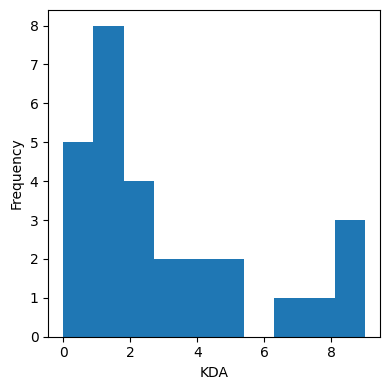

In [ ]:
ax=(harry["KDA"]).plot.hist(figsize=(4,4))
ax.set_xlabel("KDA")
plt.tight_layout()
plt.show()

In [ ]:
promedios = (
    harry
    .groupby("lane")
    .agg(KDA_promedio=("KDA", "mean"),Partidas=("KDA", "count"))
    .reset_index()
    .sort_values(by="KDA_promedio", ascending=True)
)
promedios


,lane,KDA_promedio,Partidas
0,BOTTOM,1.464286,2
4,TOP,2.066440,7
2,MIDDLE,3.074264,15
3,NONE,4.000000,1
1,JUNGLE,7.222222,3


In [ ]:
promedios = (
    harry
    .groupby("championName")
    .agg(
        KDA_promedio=("KDA", "mean"),
        Partidas=("KDA", "count"),
        Victorias=("win", "sum")   # la usamos solo para calcular %
    )
    .reset_index()
)

# Crear porcentaje de victorias
promedios["Porcentaje_Victorias"] = (
    promedios["Victorias"] / promedios["Partidas"] * 100
)

# Eliminar columna de Victorias
promedios = promedios.drop(columns="Victorias")

# Ordenar por KDA promedio
promedios = promedios.sort_values(by="Partidas", ascending=True)

promedios

,championName,KDA_promedio,Partidas,Porcentaje_Victorias
0,Annie,4.000000,1,0.000000
2,Aurora,3.555556,1,100.000000
3,Blitzcrank,1.428571,1,0.000000
7,Jhin,1.500000,1,0.000000
6,Jax,2.250000,1,0.000000
11,Ornn,1.142857,1,100.000000
10,Nasus,1.600000,1,100.000000
8,Karma,3.666667,1,100.000000
1,AurelionSol,1.200000,2,0.000000
5,Galio,5.777778,2,100.000000


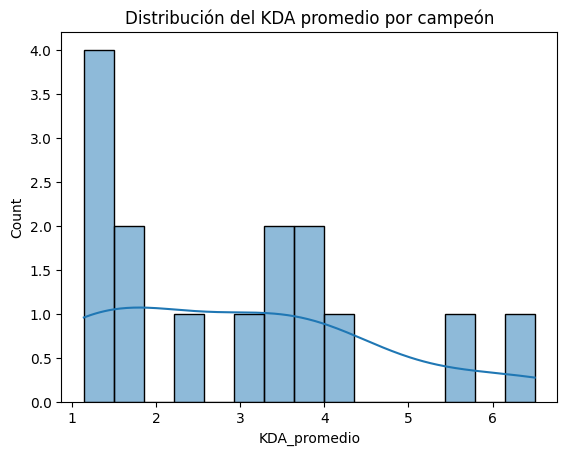

In [ ]:
sns.histplot(data=promedios, x="KDA_promedio", kde=True, bins=15)
plt.title("Distribución del KDA promedio por campeón")
plt.show()


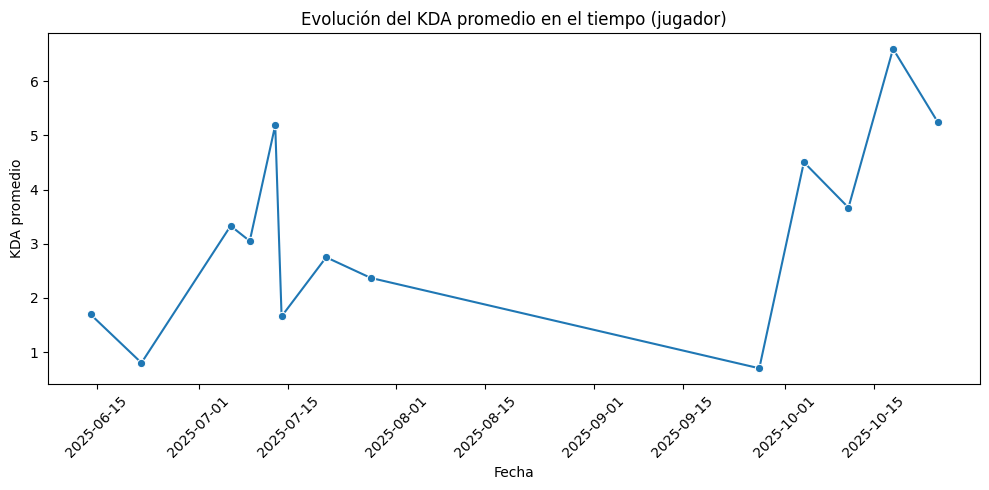

In [ ]:
# Asegúrate de tener fecha en formato date
harry["fecha"] = pd.to_datetime(harry["gameCreation"], unit="ms").dt.date

# KDA promedio por fecha (por jugador harry)
rendimiento_tiempo = (
    harry.groupby("fecha")["KDA"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.lineplot(data=rendimiento_tiempo, x="fecha", y="KDA", marker="o")
plt.title("Evolución del KDA promedio en el tiempo (jugador)")
plt.xlabel("Fecha")
plt.ylabel("KDA promedio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



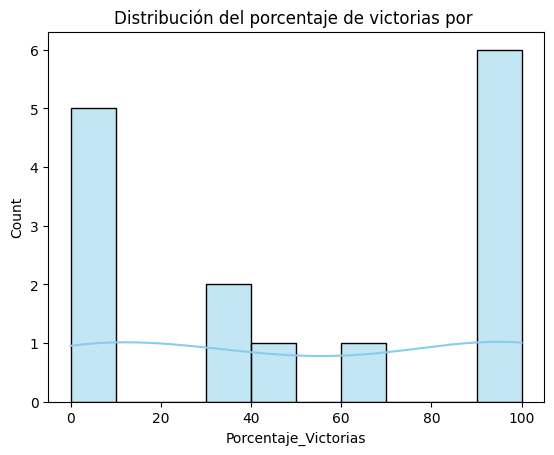

In [ ]:
sns.histplot(data=promedios, x="Porcentaje_Victorias", kde=True, bins=10, color="skyblue")
plt.title("Distribución del porcentaje de victorias")
plt.show()


/tmp/ipython-input-3812713583.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=promedios, x="Categoria", palette="Set2")


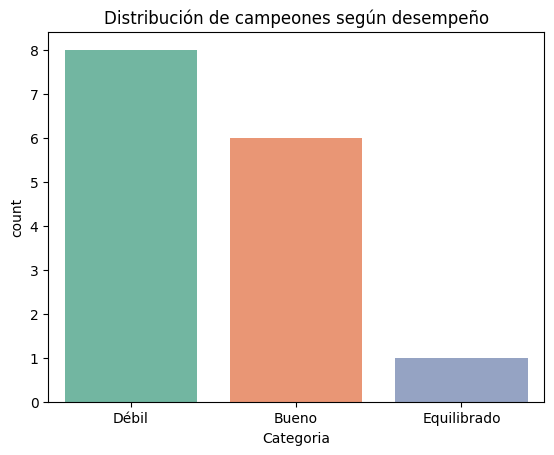

In [ ]:
def clasificar_campeon(row):
    if row["Porcentaje_Victorias"] >= 70:
        return "Bueno"
    elif row["Porcentaje_Victorias"] >= 50:
        return "Equilibrado"
    else:
        return "Débil"

promedios["Categoria"] = promedios.apply(clasificar_campeon, axis=1)

sns.countplot(data=promedios, x="Categoria", palette="Set2")
plt.title("Distribución de campeones según desempeño")
plt.show()


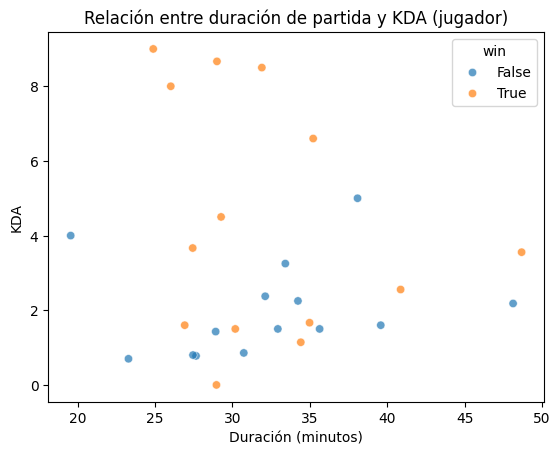

In [ ]:
# Crear la columna de duración en minutos
harry["duracion_min"] = harry["gameDuration"] / 60

# Ahora sí, hacer el gráfico
sns.scatterplot(
    data=harry,
    x="duracion_min",
    y="KDA",
    hue="win",
    alpha=0.7
)
plt.title("Relación entre duración de partida y KDA (jugador)")
plt.xlabel("Duración (minutos)")
plt.ylabel("KDA")
plt.show()


In [ ]:
harry["win"] = harry["win"].astype(str).str.lower().map({"true": 1, "false": 0})

/tmp/ipython-input-108595198.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


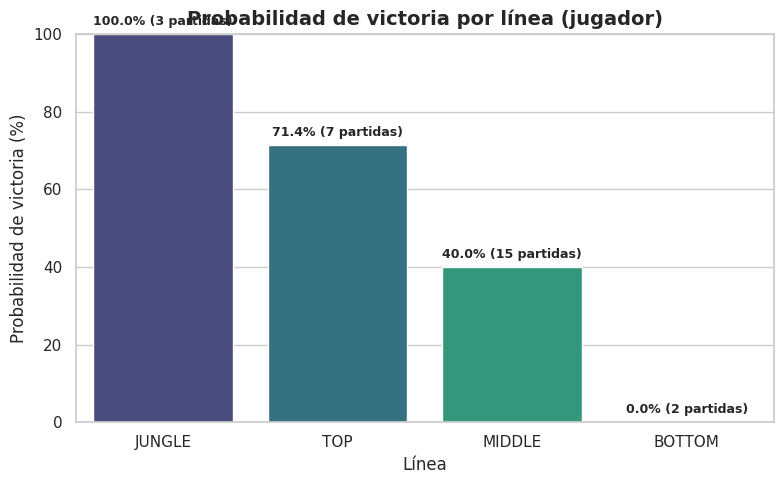

In [ ]:
# Calcular probabilidad de victoria y cantidad de partidas por línea
prob_por_linea = (
    harry.groupby("lane")
    .agg(
        Probabilidad_Victoria=("win", "mean"),
        Partidas=("win", "count")
    )
    .reset_index()
    .sort_values("Probabilidad_Victoria", ascending=False)
)

# Convertir a porcentaje
prob_por_linea["Probabilidad_Victoria"] *= 100

# Eliminar nulos o líneas "NONE"
prob_por_linea = prob_por_linea[
    prob_por_linea["lane"].notna() & (prob_por_linea["lane"] != "NONE")
]

# Estilo visual
sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=prob_por_linea,
    x="lane",
    y="Probabilidad_Victoria",
    palette="viridis",
    order=prob_por_linea["lane"]
)

plt.title("Probabilidad de victoria por línea (jugador)", fontsize=14, weight="bold")
plt.xlabel("Línea", fontsize=12)
plt.ylabel("Probabilidad de victoria (%)", fontsize=12)
plt.ylim(0, 100)

# ✅ Mostrar el porcentaje y número de partidas encima de cada barra
for bar, (_, row) in zip(ax.patches, prob_por_linea.iterrows()):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(
        x, y + 1.5,
        f"{y:.1f}% ({row['Partidas']} partidas)",
        ha="center", va="bottom", fontsize=9, weight="bold"
    )

plt.tight_layout()
plt.show()



In [ ]:
def fase_partida(duracion):
    if duracion < 20:
        return "Early"
    elif duracion < 30  :
        return "Mid"
    else:
        return "Late"

harry["fase_juego"] = harry["duracion_min"].apply(fase_partida)


In [ ]:
prob_victorias_fase = harry.groupby("fase_juego")["win"].mean().reset_index()
prob_victorias_fase.rename(columns={"win": "probabilidad_victoria"}, inplace=True)
print(prob_victorias_fase)


  fase_juego  probabilidad_victoria
0      Early               0.000000
1       Late               0.437500
2        Mid               0.636364


/tmp/ipython-input-1775076184.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


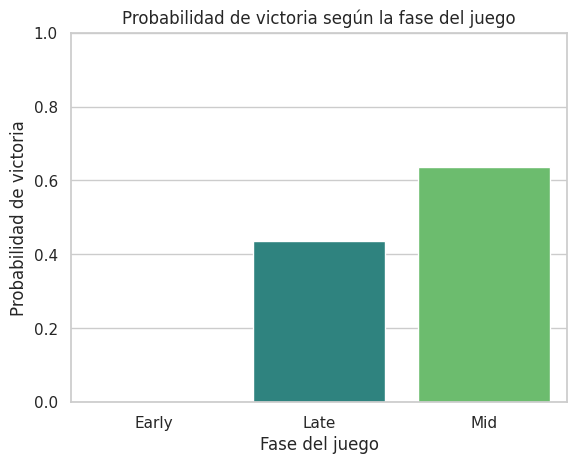

In [ ]:
sns.barplot(
    data=prob_victorias_fase,
    x="fase_juego",
    y="probabilidad_victoria",
    palette="viridis"
)
plt.title("Probabilidad de victoria según la fase del juego")
plt.ylabel("Probabilidad de victoria")
plt.xlabel("Fase del juego")
plt.ylim(0, 1)
plt.show()
